# Read and Visualize a WSI

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/01-wsi-reading.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/01-wsi-reading.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



### About this demo

This demo reads a whole slide image (WSI) using tiatoolbox. We load a sample WSI, gather some key information, and then extract some image patches. We demo our modules
`wsireader` [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/wsicore/wsireader.py) and
`slide_info` [details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/wsicore/slide_info.py).



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [14]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."

0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Installation is done.


  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-q6j8mllz


**IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *Runtime→Restart runtime*. This is needed to load the latest versions of prerequisite packages installed with TIATool. Having done this, you can do *Runtime→Run all* or *Runtime→Run after* or run the remaining cells one by one.



### Removing leftovers from previous runs

The cell below removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.



In [15]:
%%bash
rm -rf tmp
echo "deleting tmp directory"

deleting tmp directory


### Set Up Plotting

Here we import `matplotlib` and set some options for plotting results to make the output look nice.



In [16]:
"""Import modules required to run the Jupyter notebook."""

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

# Pretty print for nice dictionary printing
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt

from tiatoolbox import logger
from tiatoolbox.data import small_svs
from tiatoolbox.wsicore.wsireader import WSIReader

mpl.rcParams["figure.dpi"] = 150  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
plt.rcParams.update({"font.size": 5})

## Reading in a WSI

We load a small WSI, specified with the help of the data module. Here we include a function to download a small sample SVS image from our server. This function then returns the path to the downloaded file which is stored in your system's temporary directory, e.g. `/tmp` on UNIX-like systems.



In [27]:
file_path = "/content/aa.png"
logger.info(file_path)

Our code shields the user from the incompatible formats produced by different models of scanners from different vendors. The function `WSIReader.open` has as input a particular WSI, with a particular image format, and outputs an object `reader`, whose base class is `WSIReader`, and whose derived class depends on the image format ([see details](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/wsicore/wsireader.py)). The reader `reader` provides important information about the WSI. Member functions obtain pixel- or patch-level information, using format-independent code, as we illustrate below.



In [28]:
reader = WSIReader.open(file_path)
print(reader)  # noqa: T201

First, let's check the basic WSI information, such as magnification, dimension, etc.
(`mpp` = microns per pixel).



In [29]:
info_dict = reader.info.as_dict()
pprint(info_dict)  # noqa: T203

Raw data is None.
Unknown scale (no objective_power or mpp)


{'axes': 'YSX',
 'file_path': PosixPath('/content/aa.png'),
 'level_count': 1,
 'level_dimensions': ((360, 361),),
 'level_downsamples': [1.0],
 'mpp': (None, None),
 'objective_power': None,
 'slide_dimensions': (360, 361),
 'vendor': 'None'}


### Thumbnail

To see a thumbnail of the WSI, we use the `slide_thumbnail` method of `reader`.
We load the thumbnail at $\times1.25$ objective power as follows:



Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


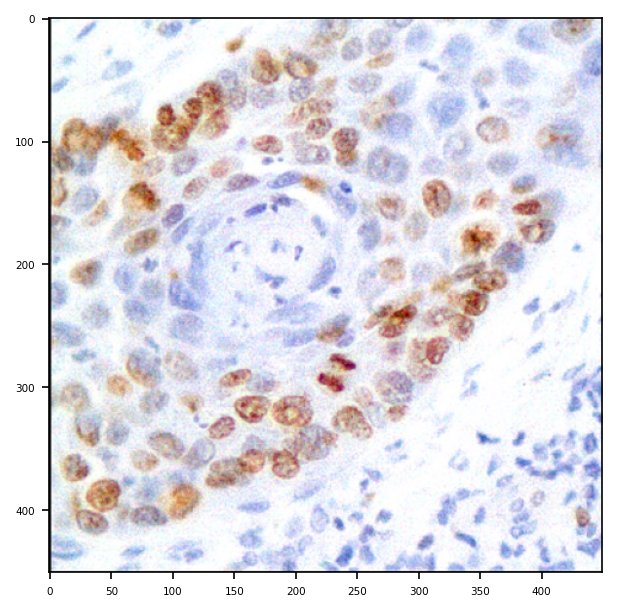

In [35]:
thumbnail = reader.slide_thumbnail(resolution=1.25, units="baseline")
plt.imshow(thumbnail)
plt.axis("on")
plt.show()

## Reading WSI regions

### i) Read Rect

We can read a region of the whole slide image at a given location and size using the `read_rect` method. Location can be stated as (x, y) tuple giving the top left pixel in the baseline (level 0) reference frame, and size as (width, height) tuple giving the desired output image size.

Reads can be performed at different resolutions by supplying a pair of arguments for the `resolution` and the `units` of resolution. `resolution` can be given as integer or float or tuple(float), default = 0. Either a single number or a sequence of two numbers for x and y as tuple are valid. This value is in terms of the corresponding units. For example: resolution=0.5 and units=''mpp'' will read the slide at 0.5 microns per-pixel, and resolution=3, units=''level'' will read at level at pyramid level / resolution layer 3. Supported units are: microns per pixel (''mpp''), objective power (''power''), pyramid / resolution level (''level''), pixels per baseline pixel (''baseline''), default =''level''.



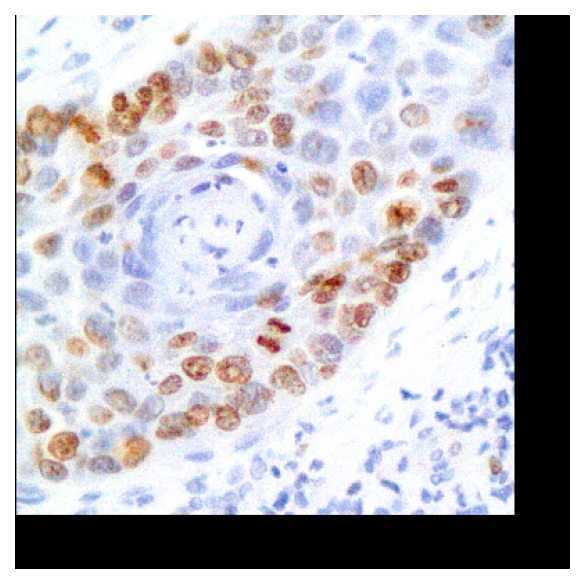

In [41]:
# Location coordinates in (x,y)
location = (0, 0)

# Size of the region in (width, height)
size = (400, 400)

# read the region using wsi reader's read rect at 0.5 mpp
img = reader.read_rect(
    location,
    size,
    resolution=1,
    units="baseline",
)

plt.imshow(img)
plt.axis("off")
plt.show()

### ii) Read bound

Read a region of the whole slide image within given bounds. Bounds is a tuple of (start_x, start_y, end_x, end_y) i.e., (left, top, right, bottom) of the region in baseline reference frame. However, with coord_space=''resolution'', the bound is expected to be at the requested `resolution` system.

Reads can be performed at different resolutions by supplying a pair of arguments for the resolution and the units of resolution. resolution can be given as integer or float or tuple(float), default = 0. Either a single number or a sequence of two numbers for x and y as tuple are valid. This value is in terms of the corresponding units. For example: resolution=0.5 and units=''mpp'' will read the slide at 0.5 microns per-pixel, and resolution=3, units=''level'' will read at level at pyramid level / resolution layer 3. Supported units are: microns per pixel (''mpp''), objective power (''power''), pyramid / resolution level (''level''), pixels per baseline pixel (''baseline''), default =''level''.

coord_space = ''baseline'' by default, this is a flag to indicate if the input bounds is in the baseline coordinate system (''baseline'') or is in the requested resolution system (''resolution'').



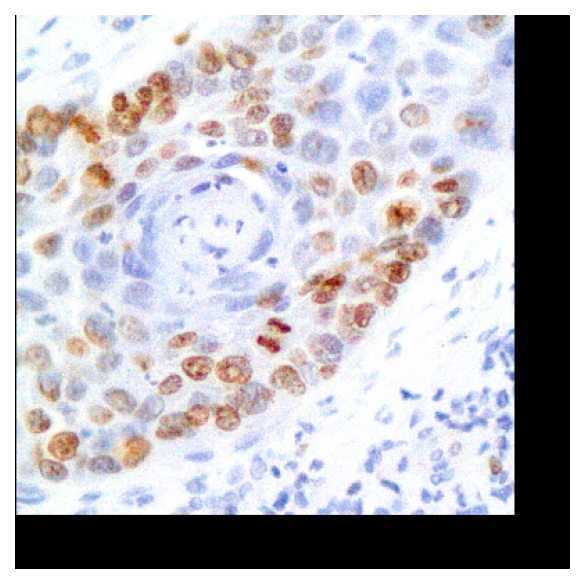

In [44]:
# Specify the bounds in terms of rectangle (left, top, right, bottom)
bounds = [0, 0, 400, 400]

# Read the region using wsi reader's read bounds at level 0
img = reader.read_bounds(bounds, resolution=0, units="level")

plt.imshow(img)
plt.axis("off")
plt.show()

## Tissue Masking

It is often useful to distinguish between tissue and glass (no tissue) in the image. For example, to avoid running computation expensive analysis for regions where is no tissue content. We compute a *mask*, by which we mean a binary colouring of the pixels to either black=glass or white=tissue. The white area is deliberately made a little larger than tissue area, as this will be appropriate for our task. We provide a function `tissue_mask` on a `WSIReader` binarises the thumbnail on the basis of pixel intensity, using the Otsu method. Morphological operations improve the result.

Note that the `tissue_mask` function returns a `VirtualWSIReader` object rather than a NumPy array (although this can be accessed via the `.image` attribute). The returned `VirtualWSIReader` object also has some metadata copied from the original WSI. This allows the lower resolution mask image to be read as it it were the full size WSI. This is particularly useful as it allows for using the same coordinates to read from the mask as from the original WSI.



Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


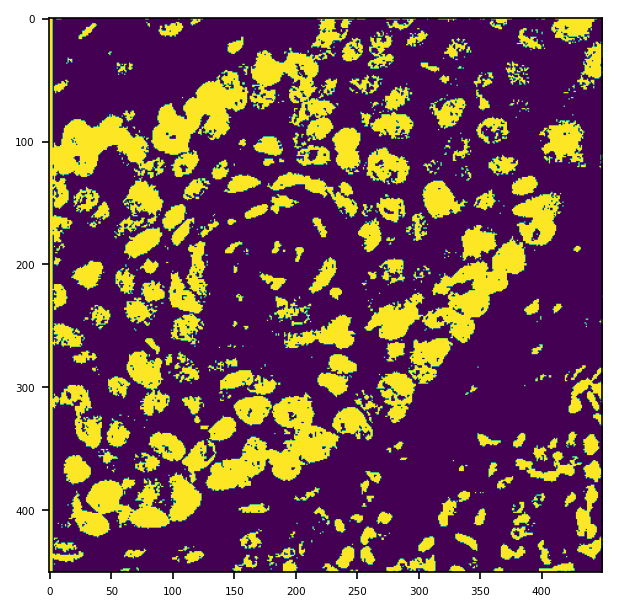

In [48]:
mask_reader = reader.tissue_mask(resolution=4, units="baseline")
mask_thumbnail = mask_reader.slide_thumbnail(resolution=1.25, units="baseline")

plt.imshow(mask_thumbnail)
plt.show()

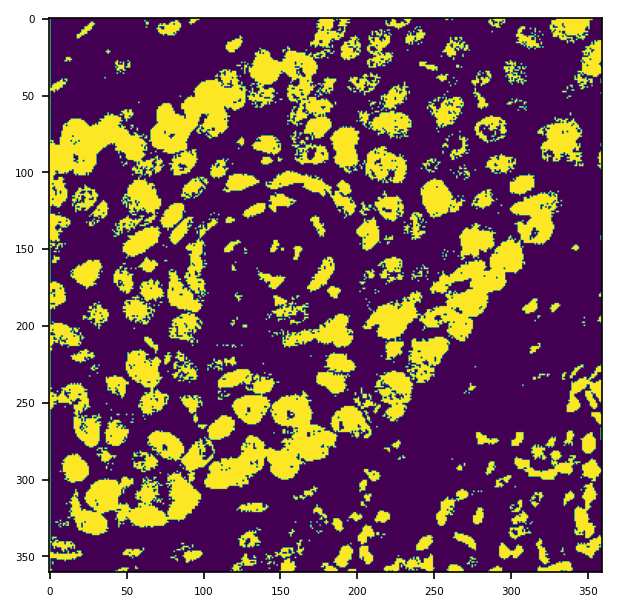

In [51]:
mask_reader = reader.tissue_mask("morphological", resolution=0, units="level")
mask_thumbnail = mask_reader.slide_thumbnail(resolution=1.25, units="baseline")

plt.imshow(mask_thumbnail)
plt.show()

In [ ]:
mask_reader = reader.tissue_mask("morphological", resolution=0, units="level")
mask_thumbnail = mask_reader.slide_thumbnail(resolution=1.25, units="baseline")

plt.imshow(mask_thumbnail)
plt.show()

Here we show reading part of the tissue from `reader` and also the corresponding part of the mask.



In [ ]:
tissue_region = reader.read_rect(
    location=(1500, 1500),
    size=(500, 500),
    resolution=0.5,
    units="mpp",
)
mask_region = mask_reader.read_rect(
    location=(1500, 1500),
    size=(500, 500),
    resolution=0.5,
    units="mpp",
)
_, axs = plt.subplots(1, 2)
axs[0].imshow(tissue_region)
axs[1].imshow(mask_region, vmin=0, vmax=1)
plt.show()

Notice that the above two function calls to the two reader objects have identical arguments. This could also be written more concisely as follows:



In [ ]:
# Try modifying the parameters and see how the mask changes
location, size = (1500, 1500), (500, 500)
tissue_region, mask_region = (
    r.read_rect(location, size, 0.5, "mpp") for r in (reader, mask_reader)
)
_, axs = plt.subplots(1, 2)
axs[0].imshow(tissue_region)
axs[1].imshow(mask_region, vmin=0, vmax=1)
plt.show()